# ISLR Chapter 8 - End of Chapter Applied exercises code portion solutions¶

Exercises from: "An Introduction to Statistical Learning with Applications in R" (Springer, 2013) by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani

Data: http://faculty.marshall.usc.edu/gareth-james/ISL/data.html

Code Solutions by Arthur Avila

### 7. In the lab, we applied random forests to the `Boston` data using `mtry=6` and using `ntree=25` and `ntree=500`. Create a plot displaying the test error resulting from random forests on this data set for a more comprehensive range of values for `mtry` and `ntree`. You can model your plot after Figure 8.10. Describe the results obtained.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=555)

ntrees = np.arange(10,250,10)
max_features = np.arange(1,X_train.shape[1]+1)

def rfmse(trees, features, X, Xtest, y, ytest):
    rf = RandomForestRegressor(n_estimators = trees, max_features = features, n_jobs=-1)
    rf.fit(X,y)
    ypred = rf.predict(Xtest)
    return(mean_squared_error(ytest,ypred))

results = []
for trees, features in product(ntrees, max_features):
    results.append([trees, features, rfmse(trees, features, X_train, X_test, y_train, y_test)])  

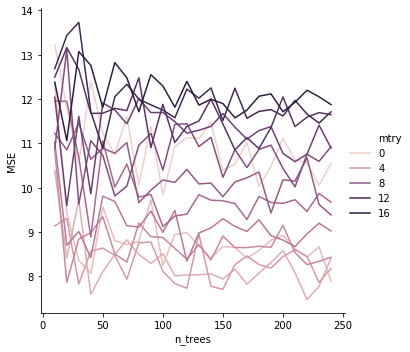

In [3]:
plot_data = pd.DataFrame(results, columns=['n_trees','mtry','MSE'])
sns.relplot('n_trees','MSE', data=plot_data, hue = 'mtry', kind='line')
plt.show()

### 8. In the lab, a classification tree was applied to the `Carseats` data set after converting `Sales` into a qualitative response variable. Now we will seek to predict `Sales` using regression trees and related approaches, treating the response as a quantitative variable.

#### (a) Split the data set into a training set and a test set.

In [4]:
Carseats = pd.read_csv('Carseats.csv', index_col=0)
Carseats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 1 to 400
Data columns (total 11 columns):
Sales          400 non-null float64
CompPrice      400 non-null int64
Income         400 non-null int64
Advertising    400 non-null int64
Population     400 non-null int64
Price          400 non-null int64
ShelveLoc      400 non-null object
Age            400 non-null int64
Education      400 non-null int64
Urban          400 non-null object
US             400 non-null object
dtypes: float64(1), int64(7), object(3)
memory usage: 37.5+ KB


In [5]:
y = Carseats.Sales
X = Carseats.drop('Sales', axis=1)
categorical = X.select_dtypes(include='object').columns.to_list()
numeric = X.select_dtypes(exclude='object').columns.to_list()

In [6]:
from sklearn.model_selection import train_test_split
np.random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)

#### (b) Fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain?

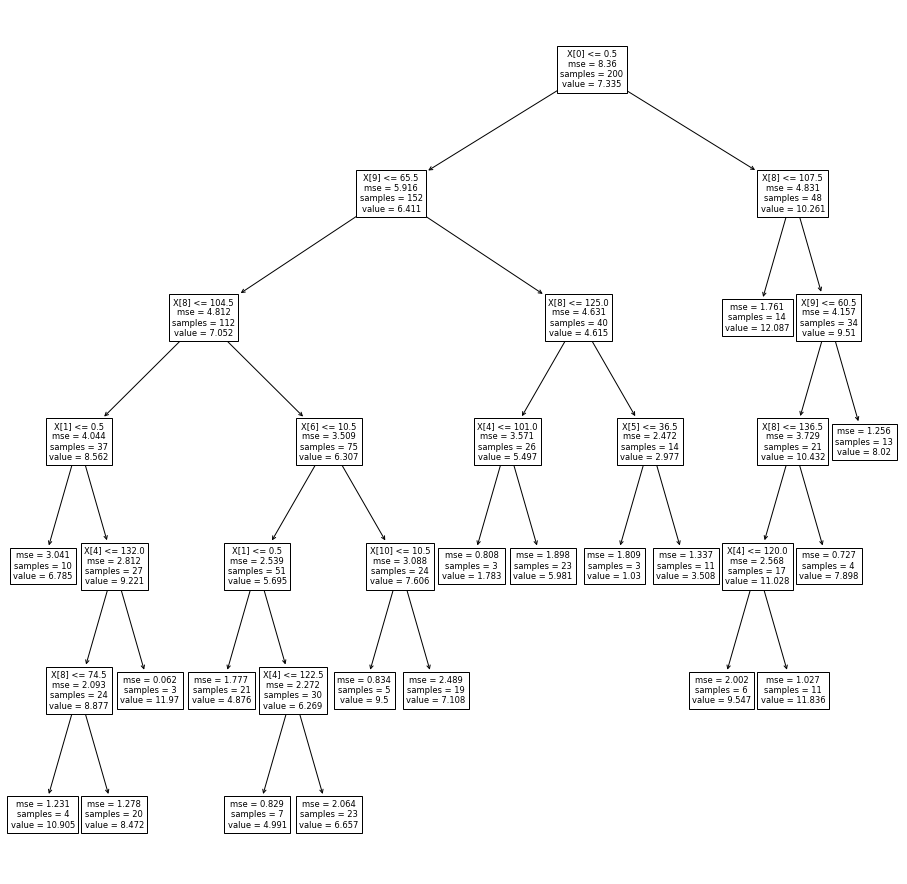

In [7]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('dummy', OneHotEncoder(drop='first', sparse=False),categorical),],
    remainder='passthrough')


car_tree = DecisionTreeRegressor(max_leaf_nodes=18).fit(preprocessor.fit_transform(X_train), y_train)
plt.figure(figsize=(16,16))
plot_tree(car_tree)
plt.show()

In [8]:
mean_squared_error(y_test, car_tree.predict(preprocessor.fit_transform(X_test)))

5.5550272314021

#### (c) Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE?

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('dummy',preprocessor),
    ('tree', DecisionTreeRegressor())
])

params = {'tree__max_leaf_nodes':np.arange(1,33)}

cv_tree = GridSearchCV(pipe, params, cv=10, iid=False, n_jobs=-1, scoring = 'neg_mean_squared_error')
cv_tree.fit(X_train, y_train)
print('Best tree size is: ', cv_tree.best_params_['tree__max_leaf_nodes'])
print('Best MSE in CV: ', -cv_tree.best_score_)
print('Test MSE: ', mean_squared_error(y_test, cv_tree.predict(X_test)))

Best tree size is:  16
Best MSE in CV:  4.42339848338792
Test MSE:  5.5743759061309195


/home/arthur/anaconda3/envs/stats/lib/python3.7/site-packages/sklearn/model_selection/_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


#### (d) Use the bagging approach in order to analyze this data. What test MSE do you obtain? Use the `importance()` function to determine which variables are most important.

In [10]:
from sklearn.ensemble import RandomForestRegressor
# there is a Bagging Regressor, but with no feature importances
np.random.seed(34)
rf = RandomForestRegressor() #default max features is equivalent to DecisionTree bagging
rf.fit(preprocessor.fit_transform(X_train),y_train)
rf.feature_importances_

array([0.33352426, 0.06931024, 0.0052398 , 0.00524145, 0.07725851,
       0.04505765, 0.06389157, 0.03422325, 0.21732181, 0.11130819,
       0.03762327])

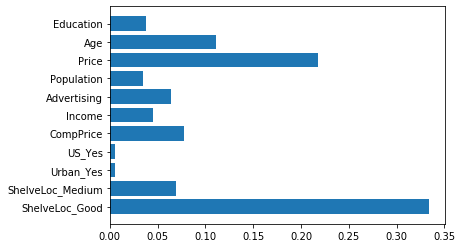

In [11]:
feature_names = pd.get_dummies(X[categorical], drop_first=True).columns.to_list()+numeric

plt.barh(feature_names, rf.feature_importances_)
plt.show()

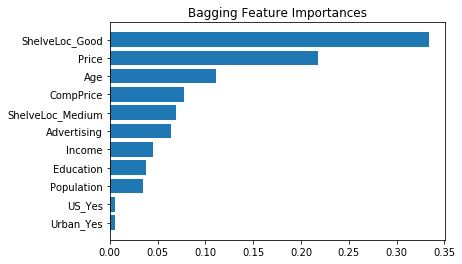

In [12]:
order = [list(rf.feature_importances_).index(x) for x in np.sort(rf.feature_importances_)]
plot_names = [feature_names[x] for x in order]
plot_values = [rf.feature_importances_[x] for x in order]

plt.barh(plot_names, plot_values)
plt.title('Bagging Feature Importances')
plt.show()

#### (e) Use random forests to analyze this data. What test MSE do you obtain? Use the `importance()` function to determine which variables are most important. Describe the effect of $m$, the number of variables considered at each split, on the error rate obtained.

In [13]:
rf = RandomForestRegressor(random_state=34)
rf_mse = []
n_feats = np.arange(1,len(feature_names)+1)
for n_feat in n_feats:
    rf.set_params(max_features=n_feat)
    rf.fit(preprocessor.fit_transform(X_train),y_train)
    y_pred = rf.predict(preprocessor.fit_transform(X_test))
    rf_mse.append(mean_squared_error(y_pred,y_test))
print(rf_mse)

[4.44366811875, 3.7544278752, 3.4568665156000002, 3.25670562075, 3.016618539049999, 3.194943799000001, 3.1384877337000012, 3.2484276436000004, 3.1729460030000007, 3.1412261753500004, 3.167326943650002]


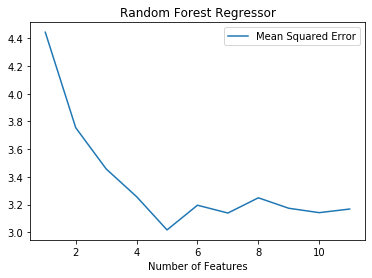

In [14]:
plt.plot(n_feats, rf_mse, label='Mean Squared Error')
plt.xlabel('Number of Features')
plt.legend()
plt.title('Random Forest Regressor')
plt.show()

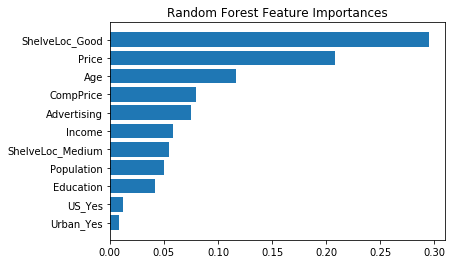

In [15]:
n_feat = n_feats[np.argmin(rf_mse)]
rf.set_params(max_features=n_feat)
rf.fit(preprocessor.fit_transform(X_train),y_train)
order = [list(rf.feature_importances_).index(x) for x in np.sort(rf.feature_importances_)]
plot_names = [feature_names[x] for x in order]
plot_values = [rf.feature_importances_[x] for x in order]

plt.barh(plot_names, plot_values)
plt.title('Random Forest Feature Importances')
plt.show()

### 9. This problem involves the OJ data set which is part of the ISLR package.

#### (a) Create a training set containing a random sample of 800 observations, and a test set containing the remaining observations.

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

OJ = pd.read_csv('OJ.csv', index_col=0)

y = np.array(OJ.Purchase == 'CH').astype('int')
X = pd.get_dummies(OJ.drop('Purchase', axis=1), drop_first=True)
print(X.info())

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=800, random_state=123)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1070 entries, 1 to 1070
Data columns (total 17 columns):
WeekofPurchase    1070 non-null int64
StoreID           1070 non-null int64
PriceCH           1070 non-null float64
PriceMM           1070 non-null float64
DiscCH            1070 non-null float64
DiscMM            1070 non-null float64
SpecialCH         1070 non-null int64
SpecialMM         1070 non-null int64
LoyalCH           1070 non-null float64
SalePriceMM       1070 non-null float64
SalePriceCH       1070 non-null float64
PriceDiff         1070 non-null float64
PctDiscMM         1070 non-null float64
PctDiscCH         1070 non-null float64
ListPriceDiff     1070 non-null float64
STORE             1070 non-null int64
Store7_Yes        1070 non-null uint8
dtypes: float64(11), int64(5), uint8(1)
memory usage: 143.2 KB
None


#### (b) Fit a tree to the training data, with Purchase as the response and the other variables as predictors. Use the summary() function to produce summary statistics about the tree, and describe the results obtained. What is the training error rate? How many terminal nodes does the tree have?

In [17]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=34)
tree_clf.fit(X_train, y_train)
fit_accuracy = tree_clf.score(X_train, y_train)
n_terminal = tree_clf.get_n_leaves()
print('The fitted accuracy is %.3f and the number of terminal nodes is %s.' 
      % (fit_accuracy, n_terminal))

The fitted accuracy is 0.988 and the number of terminal nodes is 175.


#### (c) Type in the name of the tree object in order to get a detailed text output. Pick one of the terminal nodes, and interpret the information displayed.

#### (d) Create a plot of the tree, and interpret the results.

#### (e) Predict the response on the test data, and produce a confusion matrix comparing the test labels to the predicted test labels. What is the test error rate?

#### (f) Apply the cv.tree() function to the training set in order to determine the optimal tree size.

#### (g) Produce a plot with tree size on the x-axis and cross-validated classification error rate on the y-axis.

#### (h) Which tree size corresponds to the lowest cross-validated classification error rate?

#### (i) Produce a pruned tree corresponding to the optimal tree size obtained using cross-validation. If cross-validation does not lead to selection of a pruned tree, then create a pruned tree with five terminal nodes.

#### (j) Compare the training error rates between the pruned and unpruned trees. Which is higher?

#### (k) Compare the test error rates between the pruned and unpruned trees. Which is higher?

In [18]:
# The tree package in R sets a standard limitation on tree size. 
# Python does not. The resulting tree is much bigger.

In [19]:
path = tree_clf.cost_complexity_pruning_path(X_train, y_train)
tree_clfs = []
for ccp_alpha in path.ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    tree_clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      tree_clfs[-1].tree_.node_count, path.ccp_alphas[-1]))


Number of nodes in the last tree is: 3 with ccp_alpha: 0.17268158425297103


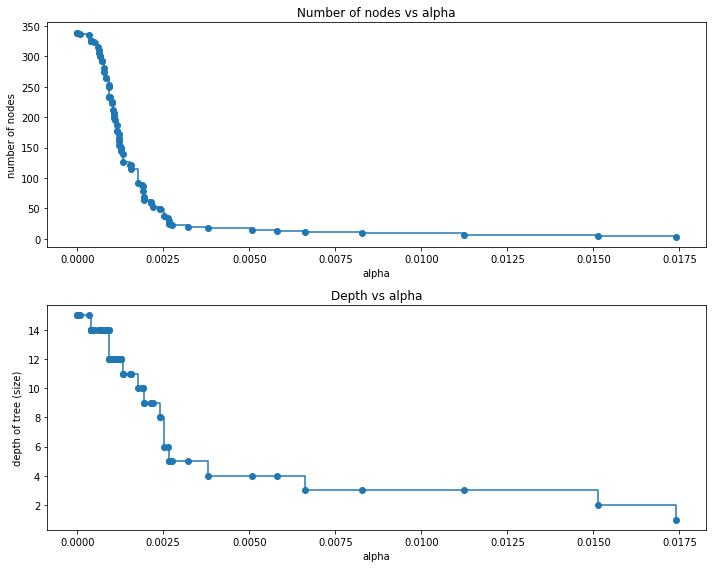

In [20]:
node_counts = [clf.tree_.node_count for clf in tree_clfs]
depth = [clf.tree_.max_depth for clf in tree_clfs]
fig, ax = plt.subplots(2, 1, figsize=(10,8))
ax[0].plot(path.ccp_alphas[:-1], node_counts[:-1], marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(path.ccp_alphas[:-1], depth[:-1], marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree (size)")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

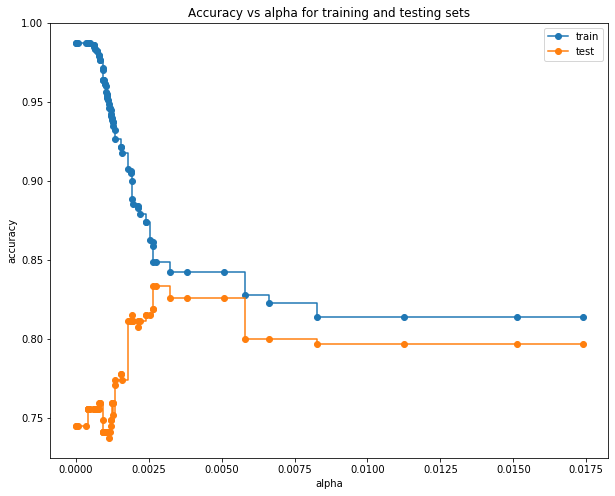

In [21]:
train_scores = [clf.score(X_train, y_train) for clf in tree_clfs]
test_scores = [clf.score(X_test, y_test) for clf in tree_clfs]

fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(path.ccp_alphas[:-1], train_scores[:-1], marker='o', label="train",
        drawstyle="steps-post")
ax.plot(path.ccp_alphas[:-1], test_scores[:-1], marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix

y_pred = tree_clf.predict(X_test)
y_fit = tree_clf.predict(X_train)

print('Confusion matrix for unpruned tree on training data:')
print(confusion_matrix(y_train, y_fit))
print('The accuracy score is %.3f' % tree_clf.score(X_train, y_train))

print('Confusion matrix for unpruned tree on test data:')
print(confusion_matrix(y_test, y_pred))
print('The accuracy score is %.3f' % tree_clf.score(X_test, y_test))


Confusion matrix for unpruned tree on training data:
[[305   0]
 [ 10 485]]
The accuracy score is 0.988
Confusion matrix for unpruned tree on test data:
[[ 81  31]
 [ 37 121]]
The accuracy score is 0.748


In [23]:
idx = np.argmax(test_scores)

y_pred = tree_clfs[idx].predict(X_test)
y_fit = tree_clfs[idx].predict(X_train)

print('Confusion matrix for pruned tree on training data:')
print(confusion_matrix(y_train, y_fit))
print('The accuracy score is %.3f' % tree_clfs[idx].score(X_train, y_train))

print('Confusion matrix for pruned tree on test data:')
print(confusion_matrix(y_test, y_pred))
print('The accuracy score is %.3f' % test_scores[idx])

Confusion matrix for pruned tree on training data:
[[242  63]
 [ 58 437]]
The accuracy score is 0.849
Confusion matrix for pruned tree on test data:
[[ 84  28]
 [ 17 141]]
The accuracy score is 0.833


### 10. We now use boosting to predict `Salary` in the `Hitters` data set.

#### (a) Remove the observations for whom the salary information is unknown, and then log-transform the salaries.

In [24]:
Hitters = pd.read_csv('Hitters.csv', index_col=0)
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [25]:
y = np.log(Hitters.dropna().Salary)
X = pd.get_dummies(Hitters.dropna().drop('Salary', axis=1))

#### (b) Create a training set consisting of the first 200 observations, and a test set consisting of the remaining observations.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=200, random_state=123)

#### (c) Perform boosting on the training set with 1,000 trees for a range of values of the shrinkage parameter $\lambda$. Produce a plot with different shrinkage values on the x-axis and the corresponding training set MSE on the y-axis.

#### (d) Produce a plot with different shrinkage values on the x-axis and the corresponding test set MSE on the y-axis.

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

lambdas = np.logspace(-4,0) #(0.0001,0.001,0.005, 0.0075, 0.01, 0.015, 0.02, 0.05,0.1,0.2,0.5)
boost_clfs = []
fit_scores = []
test_scores = []
for learning_rate in lambdas:
    clf = GradientBoostingRegressor(learning_rate = learning_rate, n_estimators=1000, random_state=34)
    clf.fit(X_train, y_train)
    boost_clfs.append(clf)
    fit_scores.append(mean_squared_error(clf.predict(X_train), y_train))
    test_scores.append(mean_squared_error(clf.predict(X_test), y_test))

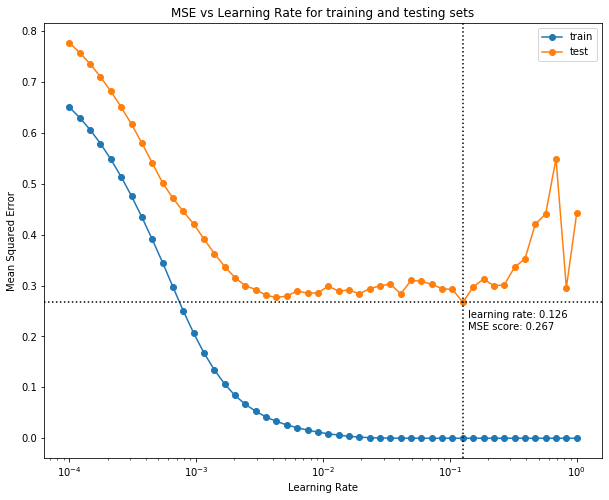

In [28]:
best_l = lambdas[np.argmin(test_scores)]
best_score = np.min(test_scores)

fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlabel("Learning Rate")
ax.set_ylabel("Mean Squared Error")
ax.set_title("MSE vs Learning Rate for training and testing sets")
ax.set_xscale('log')
ax.plot(lambdas, fit_scores, marker='o', label="train")
ax.plot(lambdas, test_scores, marker='o', label="test")
ax.axhline(best_score, ls=':', color='black')
ax.axvline(best_l, ls=':', color='black')

ax.annotate('learning rate: %.3f\nMSE score: %.3f' % (best_l, best_score), 
            xy=(best_l, best_score), 
            xytext=(1.1*best_l, 0.8*best_score))
ax.legend()
plt.show()

#### (e) Compare the test MSE of boosting to the test MSE that results from applying two of the regression approaches seen in Chapters 3 and 6.

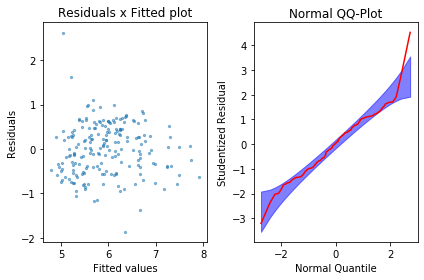

In [29]:
from sklearn.linear_model import LinearRegression
from scipy import stats

lm = LinearRegression()

def lm_plots(model, X, y, alpha=0.05):
    y_pred = model.fit(X,y).predict(X)
    resid = y - y_pred
    
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.scatter(y_pred, resid, alpha=0.5, s=5)
    ax1.set_xlabel('Fitted values')
    ax1.set_ylabel('Residuals')
    ax1.set_title('Residuals x Fitted plot')

    sort_resid = (np.sort(resid)-np.mean(resid))/np.std(resid)
    N = len(resid)
    P = (np.linspace(1,N,N) - 3/8) / (N+.25)
    dq = stats.norm.ppf(P)
    zz = stats.norm.ppf(1-alpha/2)
    SE = (1/stats.norm.pdf(dq))*np.sqrt(P*(1-P)/N)
    upper = dq+zz*SE
    lower = dq-zz*SE
    
    ax2.plot(dq, sort_resid, color='red')
    ax2.fill_between(dq, upper, lower, color='blue', alpha=0.5)
    ax2.set_xlabel('Normal Quantile')
    ax2.set_ylabel('Studentized Residual')
    ax2.set_title('Normal QQ-Plot')
    
    plt.tight_layout()
    plt.show()

lm_plots(lm, X_train, y_train)

/home/arthur/anaconda3/envs/stats/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  
/home/arthur/anaconda3/envs/stats/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  
/home/arthur/anaconda3/envs/stats/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  
/home/arthur/anaconda3/envs/stats/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  
/home/arthur/anaconda3/envs/stats/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  
/home/arthur/anaconda3/envs/stats/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


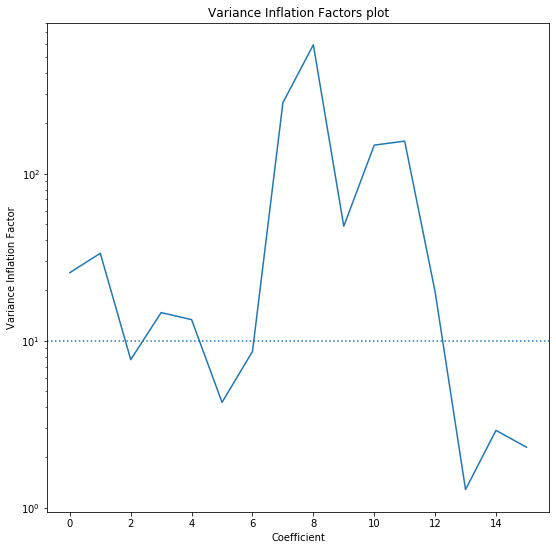

In [30]:
def vif(X):
    X = np.array(X)
    out = np.zeros(X.shape[1])
    for i in range(len(out)):
        x = np.delete(X,i,1)
        y = X[:,i]
        Ri = LinearRegression().fit(x,y).score(x,y)
        out[i] = 1/(1-Ri)
    return out

plt.figure(figsize=(9,9))
plt.plot(vif(X_train))
plt.axhline(10, ls=':')
plt.yscale('log')
plt.xlabel('Coefficient')
plt.ylabel('Variance Inflation Factor')
plt.title('Variance Inflation Factors plot')
plt.show()

In [31]:
lm.fit(X_train, y_train)
ols_mse = mean_squared_error(lm.predict(X_train), y_train)
ols_test_mse = mean_squared_error(lm.predict(X_test), y_test)

print('Linear regression MSE: %.3f.' % ols_mse,
      '\nLinear regression test MSE: %.3f.' % ols_test_mse)

Linear regression MSE: 0.336. 
Linear regression test MSE: 0.495.


In [32]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
alphas = np.logspace(-2,10,100)
l1_ratio = np.linspace(0,1,21)

ridge = RidgeCV(alphas=alphas, store_cv_values=True)
lasso = LassoCV(alphas=alphas, max_iter=100000, cv=5, n_jobs=-1)
glmnet = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratio, max_iter=10000000, cv=5, n_jobs=-1)

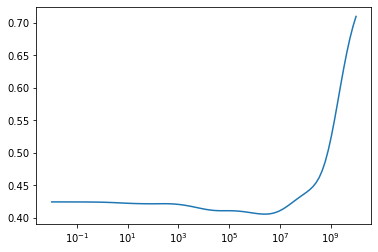

Ridge regression MSE: 0.378. 
Ridge regression test MSE: 0.583.


In [33]:
ridge.fit(X_train, y_train)
plt.plot(alphas,np.mean(ridge.cv_values_, axis=0))
plt.xscale('log')
plt.show()

print('Ridge regression MSE: %.3f.' % mean_squared_error(ridge.predict(X_train), y_train),
      '\nRidge regression test MSE: %.3f.' % mean_squared_error(ridge.predict(X_test), y_test))

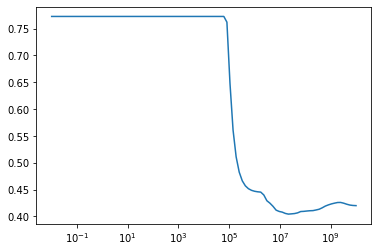

Lasso regression MSE: 0.378. 
Lasso regression test MSE: 0.578.


In [34]:
lasso.fit(X_train, y_train)
plt.plot(alphas,np.mean(lasso.mse_path_, axis=1))
plt.xscale('log')
plt.show()

print('Lasso regression MSE: %.3f.' % mean_squared_error(lasso.predict(X_train), y_train),
      '\nLasso regression test MSE: %.3f.' % mean_squared_error(lasso.predict(X_test), y_test))

In [ ]:
glmnet.fit(X_train, y_train)

/home/arthur/anaconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/arthur/anaconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/arthur/anaconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/arthur/anaconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/arthur/anaconda3/envs/stats/lib/python3.7/site

/home/arthur/anaconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.27558008826832, tolerance: 0.011261550941291639
  tol, rng, random, positive)
/home/arthur/anaconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/arthur/anaconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.83828643922899, tolerance: 0.01257470954416933
  tol, rng, random, positive)
/home/arthur/anaconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: UserWarning: Coordinate descent with alph

/home/arthur/anaconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.050982950104235, tolerance: 0.012027855616166098
  tol, rng, random, positive)
/home/arthur/anaconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/arthur/anaconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.766124387877376, tolerance: 0.01257470954416933
  tol, rng, random, positive)
/home/arthur/anaconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: UserWarning: Coordinate descent with al

In [ ]:
print('ElasticNet regression MSE: %.3f.' % mean_squared_error(glmnet.predict(X_train), y_train),
      '\nElasticNet regression test MSE: %.3f.' % mean_squared_error(glmnet.predict(X_test), y_test))

### (f) Which variables appear to be the most important predictors in the boosted model?

In [ ]:
importances = boost_clfs[np.argmin(test_scores)].feature_importances_

order = [list(importances).index(x) for x in np.sort(importances)]
plot_names = [X.columns[x] for x in order]
plot_values = [importances[x] for x in order]

plt.barh(plot_names, plot_values)
plt.title('Boosting Feature Importances')
plt.show()

### (g) Now apply bagging to the training set. What is the test set MSE for this approach?

In [ ]:
from sklearn.ensemble import BaggingRegressor
# here it is not asking for feature importances

bag = BaggingRegressor(n_estimators=1000, n_jobs=-1, random_state=34)
bag.fit(X_train, y_train)
print('Bagging of Regression Trees MSE: %.3f.' % mean_squared_error(bag.predict(X_train), y_train),
      '\nBagging of Regression Trees test MSE: %.3f.' % mean_squared_error(bag.predict(X_test), y_test))

### 11. This question uses the `Caravan` data set.

#### (a) Create a training set consisting of the first 1,000 observations, and a test set consisting of the remaining observations.

#### (b) Fit a boosting model to the training set with `Purchase` as the response and the other variables as predictors. Use 1,000 trees, and a shrinkage value of 0.01. Which predictors appear to be the most important?

#### (c) Use the boosting model to predict the response on the test data. Predict that a person will make a purchase if the estimated probability of purchase is greater than 20 %. Form a confusion matrix. What fraction of the people predicted to make a purchase do in fact make one? How does this compare with the results obtained from applying KNN or logistic regression to this data set?

In [ ]:
Caravan = pd.read_csv('Caravan.csv', index_col=0)
y_train, y_test = (Caravan.Purchase[0:1000], Caravan.Purchase[1000:])
Caravan = Caravan.drop('Purchase', axis=1)
X_train, X_test = (Caravan.iloc[0:1000,:], Caravan.iloc[1000:,:])
del(Caravan)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
boost = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000)
boost.fit(X_train, y_train)

importances = boost.feature_importances_

order = [list(importances).index(x) for x in np.sort(importances)]
plot_names = [X_train.columns[x] for x in order if x<10]
plot_values = [importances[x] for x in order if x<10]

plt.barh(plot_names, plot_values)
plt.title('Boosting Feature Importances')
plt.show()

In [ ]:
def my_clf(x):
    if x:
        return('Yes')
    else:
        return('No')
pred = boost.predict_proba(X_test)[:,1] >= .2
y_pred = pd.Series([my_clf(x) for x in pred])
print(confusion_matrix(y_test, y_pred))
tn, fn, fp, tp = confusion_matrix(y_test, y_pred, normalize = 'all').ravel()
tnr, fnr, fpr, tpr = confusion_matrix(y_test, y_pred, normalize = 'true').ravel()
print('Accuracy: %.3f' % (tn+tp))
print('False positive: %.3f%s' % (100*fpr,'%'))
print('True positive: %.3f%s' % (100*tpr,'%'))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

accuracy = []
fp = []
tp = []

for k in range(1,15,2):
    knn = KNeighborsClassifier(k)
    knn.fit(X_train, y_train)
    accuracy.append(knn.score(X_test, y_test))
    tnr, fnr, fpr, tpr = confusion_matrix(y_test, knn.predict(X_test), normalize = 'true').ravel()
    fp.append(fpr)
    tp.append(tpr)
    
pd.DataFrame({'k':[k for k in range(1,15,2)],
              'Accuracy':accuracy,
              'False positive':fp,
              'True positive':tp})

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, RFECV

logit = LogisticRegression(solver='liblinear')
selector = RFECV(logit, cv=20, n_jobs=-1)
selector.fit(X_train,y_train)

print('Number of features selected: %s' % selector.n_features_)

In [ ]:
y_pred = selector.predict(X_test)
tnr, fnr, fpr, tpr = confusion_matrix(y_test, y_pred, normalize = 'true').ravel()
print('Logistic Regression')
print('Accuracy: %.3f' % selector.score(X_test, y_test))
print('False positive: %.3f%s' % (100*fpr,'%'))
print('True positive: %.3f%s' % (100*tpr,'%'))

In [ ]:
pred = selector.predict_proba(X_test)[:,1] >= .2
y_pred = pd.Series([my_clf(x) for x in pred])
print(confusion_matrix(y_test, y_pred))
tn, fn, fp, tp = confusion_matrix(y_test, y_pred, normalize = 'all').ravel()
tnr, fnr, fpr, tpr = confusion_matrix(y_test, y_pred, normalize = 'true').ravel()
print('Logistic Regression with 20% threshold for Purchase')
print('Accuracy: %.3f' % (tn+tp))
print('False positive: %.3f%s' % (100*fpr,'%'))
print('True positive: %.3f%s' % (100*tpr,'%'))